In [16]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
import re

from sklearn.decomposition import NMF

import networkx as nx

from collections import Counter, defaultdict

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
physicians = pd.read_csv('Archive 3/physicians.csv')
procedures = pd.read_csv('Archive 3/procedures.csv')

In [85]:
physicians.head()

,id,specialty
0,0,General Surgery
1,1,Unknown
2,2,Family Practice
3,3,Emergency Medicine
4,4,Plastic and Reconstructive Surgery


In [86]:
physicians['specialty'].unique()

array(['General Surgery', 'Unknown', 'Family Practice',
       'Emergency Medicine', 'Plastic and Reconstructive Surgery',
       'Cardiology', 'Anesthesiology', 'Diagnostic Radiology',
       'Internal Medicine', 'Psychiatry', 'Pulmonary Disease',
       'Physical Medicine and Rehabilitation', 'Dermatology',
       'Hand Surgery', 'Urology', 'Critical Care (Intensivists)',
       'Ophthalmology', 'Pediatric Medicine', 'Radiation Oncology',
       'Gastroenterology', 'Orthopedic Surgery', 'Neurology',
       'Physical Therapist', 'Obstetrics/Gynecology', 'Pathology',
       'Endocrinology', 'Vascular Surgery',
       'Interventional Pain Management', 'General Practice',
       'Hematology/Oncology', 'Interventional Radiology',
       'Oral Surgery (dentists only)', 'Rheumatology', 'Otolaryngology',
       'Cardiac Surgery', 'Colorectal Surgery (formerly proctology)',
       'Allergy/Immunology', 'Addiction Medicine', 'Infectious Disease',
       'Registered Dietician/Nutrition Professi

In [140]:
print(len(physicians[physicians['specialty'] == 'Unknown']))

11092


In [ ]:
physicians.columns = []

In [ ]:
procedures = pd.merge(procedures, physicians, )

In [3]:
procedures.head()

,physician_id,procedure_code,procedure,number_of_patients
0,0,99202,"new_patient_office_or_other_outpatient_visit,_...",14
1,0,99203,"new_patient_office_or_other_outpatient_visit,_...",15
2,0,99205,"new_patient_office_or_other_outpatient_visit,_...",12
3,0,99212,established_patient_office_or_other_outpatient...,27
4,0,99213,established_patient_office_or_other_outpatient...,16


In [34]:
for i in range(20):
    print(procedures.iloc[i, 1], procedures.iloc[i, 2])

99202 new_patient_office_or_other_outpatient_visit,_typically_20_minutes
99203 new_patient_office_or_other_outpatient_visit,_typically_30_minutes
99205 new_patient_office_or_other_outpatient_visit,_typically_60_minutes
99212 established_patient_office_or_other_outpatient_visit,_typically_10_minutes
99213 established_patient_office_or_other_outpatient_visit,_typically_15_minutes
99221 initial_hospital_inpatient_care,_typically_30_minutes_per_day
99232 subsequent_hospital_inpatient_care,_typically_25_minutes_per_day
76942 ultrasonic_guidance_imaging_supervision_and_interpretation_for_insertion_of_needle
99213 established_patient_office_or_other_outpatient_visit,_typically_15_minutes
99214 established_patient_office_or_other_outpatient,_visit_typically_25_minutes
99232 subsequent_hospital_inpatient_care,_typically_25_minutes_per_day
99238 hospital_discharge_day_management,_30_minutes_or_less
99283 emergency_department_visit,_moderately_severe_problem
99284 emergency_department_visit,_prob

In [47]:
mask = pd.Series(map(lambda x: 'new_patient_office_or_other_outpatient_visit' not in x, procedures['procedure']))

In [50]:
procedures = procedures[mask]

In [51]:
docs = list(map(lambda x: ' '.join(re.split('[,_\d]+', x)), procedures['procedure']))

stops = list(stopwords.words('english'))
stops.extend(['typically', 'least', 'including', 'per', 'using'])

tfidf = TfidfVectorizer(stop_words = stops)
tfidfed = tfidf.fit_transform(docs)

vocabulary = np.array(tfidf.get_feature_names())

r_errors = []

# find the ideal number of components through iteration
for i in range(1, 10):
    nmf = NMF(n_components=i, max_iter = 100, alpha = 0)
    W = nmf.fit_transform(tfidfed)
    H = nmf.components_

    print('reconstruction error:', nmf.reconstruction_err_)
    r_errors.append(nmf.reconstruction_err_)
    
    

reconstruction error: 694.1427973788901
reconstruction error: 655.6206807097652
reconstruction error: 634.8460375149225
reconstruction error: 619.3989645850868
reconstruction error: 607.1324895308553
reconstruction error: 597.8793331529952
reconstruction error: 588.8212157797875
reconstruction error: 580.0259401150201
reconstruction error: 572.8579933492217


Text(0.5,1,'Reconstruction Error vs. n_components')

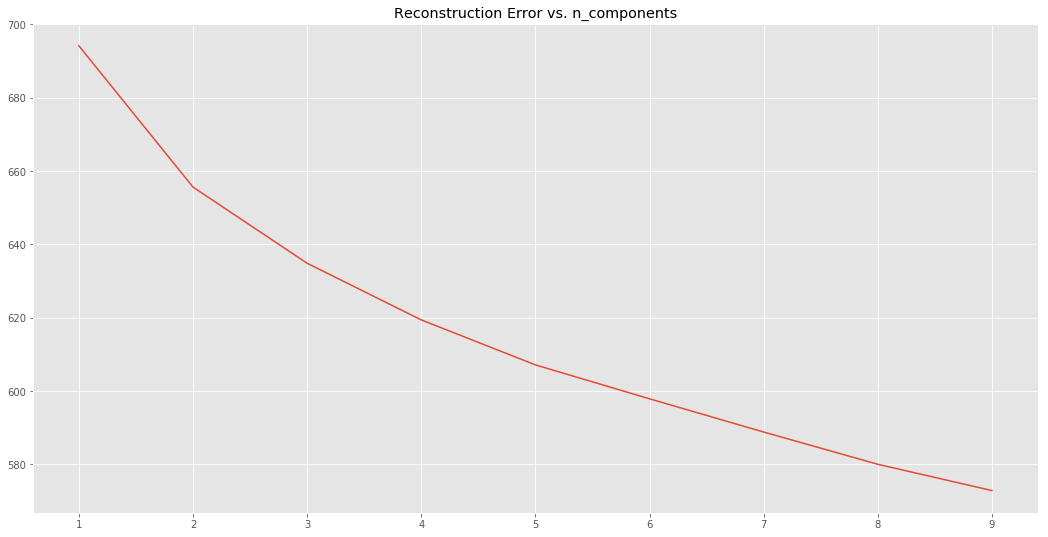

In [52]:
# plot reconstruction errors
fig = plt.figure(figsize = (18, 9))
ax = fig.add_subplot(111)
x = np.arange(1, 10)
ax.plot(x, r_errors)
ax.set_title('Reconstruction Error vs. n_components')

In [101]:
# from the graph above, let use n_components = 6
nmf = NMF(n_components=6, max_iter = 100, alpha = 0)
W = nmf.fit_transform(tfidfed)
H = nmf.components_

print('reconstruction error:', nmf.reconstruction_err_)

reconstruction error: 597.8793331272848


In [102]:
def hand_label_topics(H, vocabulary):
    '''
    Print the most influential words of each latent topic, and prompt the user
    to label each topic. The user should use their humanness to figure out what
    each latent topic is capturing.
    '''
    hand_labels = []
    for i, row in enumerate(H):
        top_five = np.argsort(row)[::-1][:50]
        print('topic', i)
        print('-->', ' '.join(vocabulary[top_five]))
        label = input('please label this topic: ')
        hand_labels.append(label)
        print()
    return hand_labels

In [103]:
hand_labels = hand_label_topics(H, vocabulary)

topic 0
--> office outpatient established visit patient minutes nursing facility home department emergency problem first ill injured critically critical delivery management service medical plan discharge annual eye personalized wellness pps includes treatment diagnosis day prevention living years older assisted subsequent visits less observation severe severity moderately high examination health services new greater

topic 1
--> hospital day care inpatient minutes subsequent initial observation discharge management less nursing facility visit injured critical critically ill delivery first severity home high health plan service moderate annual wellness pps personalized includes services face prevention counseling tobacco smoking medicare intermediate greater agency covered present reports physicians contacts affirm certification required

topic 2
--> routine leads interpretation ekg report electrocardiogram tracing hour rhythm analysis heart probe esophagus examination insertion days sy

In [105]:
hand_labels

['outpatient',
 'inpatient',
 'routine',
 'cardiopulmonary',
 'monitoring',
 'heart2']

In [106]:
procedures.head()

,physician_id,procedure_code,procedure,number_of_patients
3,0,99212,established_patient_office_or_other_outpatient...,27
4,0,99213,established_patient_office_or_other_outpatient...,16
5,0,99221,"initial_hospital_inpatient_care,_typically_30_...",13
6,0,99232,"subsequent_hospital_inpatient_care,_typically_...",12
7,1,76942,ultrasonic_guidance_imaging_supervision_and_in...,14


In [96]:
def softmax(v, temperature=1.0):
    '''
    A heuristic to convert arbitrary positive values into probabilities.
    See: https://en.wikipedia.org/wiki/Softmax_function
    '''
    expv = np.exp(v / temperature)
    s = np.sum(expv)
    return expv / s


In [132]:
def analyze_procedure(procedure_index, procedure, W, hand_labels):
    '''
    Print an analysis of a single NYT articles, including the article text
    and a summary of which topics it represents. The topics are identified
    via the hand-labels which were assigned by the user.
    '''
    print(procedure.iloc[procedure_index, :])
    probs = softmax(W[procedure_index], temperature=0.01)
    for prob, label in zip(probs, hand_labels):
        print('--> {:.2f}% {}'.format(prob * 100, label))
    print()


In [164]:
np.random.seed(12345)
rand_procedures = np.random.choice(list(range(len(W))), 5)

In [165]:
rand_procedures

array([ 77285, 395393, 347556,  86398, 421221])

In [166]:
for i in rand_procedures:
    analyze_procedure(i, procedures, W, hand_labels)

physician_id                                                       5030
procedure_code                                                    76942
procedure             ultrasonic_guidance_imaging_supervision_and_in...
number_of_patients                                                   32
Name: 81574, dtype: object
--> 11.39% outpatient
--> 11.39% inpatient
--> 20.29% routine
--> 12.43% cardiopulmonary
--> 33.10% monitoring
--> 11.39% heart2

physician_id                                                      25654
procedure_code                                                    93010
procedure             routine_electrocardiogram_(ekg)_using_at_least...
number_of_patients                                                  435
Name: 417606, dtype: object
--> 0.15% outpatient
--> 0.15% inpatient
--> 99.23% routine
--> 0.15% cardiopulmonary
--> 0.15% monitoring
--> 0.15% heart2

physician_id                                                      22596
procedure_code                            

In [198]:
# add column to show index from latent feature groupings
procedures['latent_component'] = W.argsort()[::-1][:, 0]
procedures.head()

,physician_id,procedure_code,procedure,number_of_patients,latent_component
3,0,99212,established_patient_office_or_other_outpatient...,27,2
4,0,99213,established_patient_office_or_other_outpatient...,16,2
5,0,99221,"initial_hospital_inpatient_care,_typically_30_...",13,0
6,0,99232,"subsequent_hospital_inpatient_care,_typically_...",12,4
7,1,76942,ultrasonic_guidance_imaging_supervision_and_in...,14,1


In [108]:
graph = pd.DataFrame()
graph['source'] = pd.Series(map(lambda x: 'd' + str(x), procedures['physician_id']))
graph['target'] = pd.Series(map(lambda x: 'p' + str(x), procedures['procedure_code']))
# graph['type'] = 'Undirected'

In [109]:
graph.head()

,source,target
0,d0,p99212
1,d0,p99213
2,d0,p99221
3,d0,p99232
4,d1,p76942


In [110]:
graph.shape

(556556, 2)

In [84]:
small_graph.to_csv('graph.csv', index=False, header=True, sep=';')